In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print( "Package Versions:")
import sklearn; print( "  scikit-learn:", sklearn.__version__)
import scipy; print ("  scipy:", scipy.__version__)
import statsmodels; print( "  statsmodels:", statsmodels.__version__)

Package Versions:
  scikit-learn: 1.2.2
  scipy: 1.9.1
  statsmodels: 0.13.2


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [132]:
import pandas as pd
tc_dolar = pd.read_excel(
    "Tipo de cambio.xlsx",
    sheet_name="DOLARPESO",
    index_col=[0],
    usecols=[0, 1]
)
x= tc_dolar.values
x= x.ravel()
x.shape

(96,)

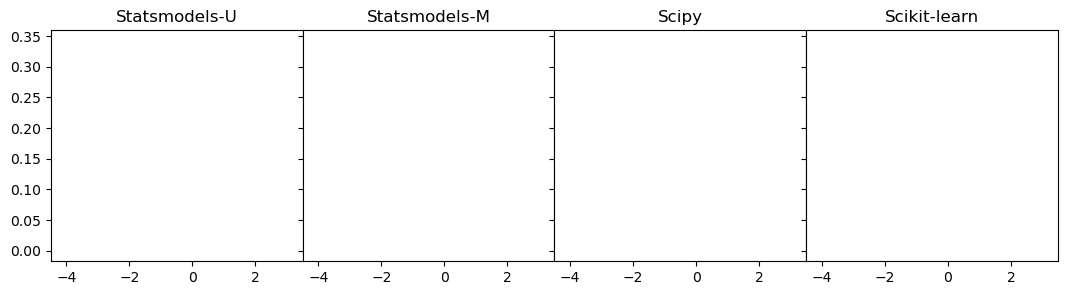

In [133]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(10, 30, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)

pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

In [5]:
import seaborn as sns

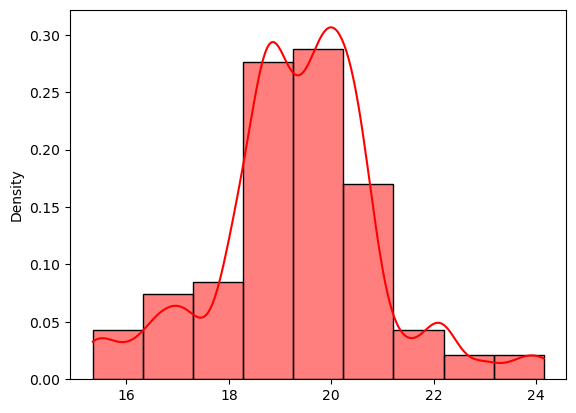

In [135]:
sns.histplot(data=x, stat='density', kde=True, kde_kws={'bw_method': .2}, color='r', bins=9);

<AxesSubplot:ylabel='Density'>

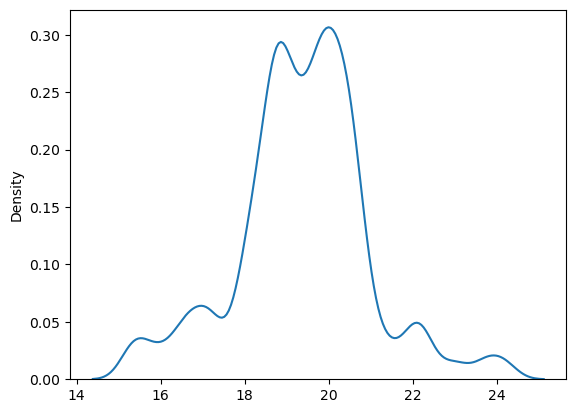

In [7]:
sns.kdeplot(data=x, bw_method=0.2)

### Bandwidth selection

The selection of bandwidth is an important piece of KDE.  For the same input data, different bandwidths can produce very different results:

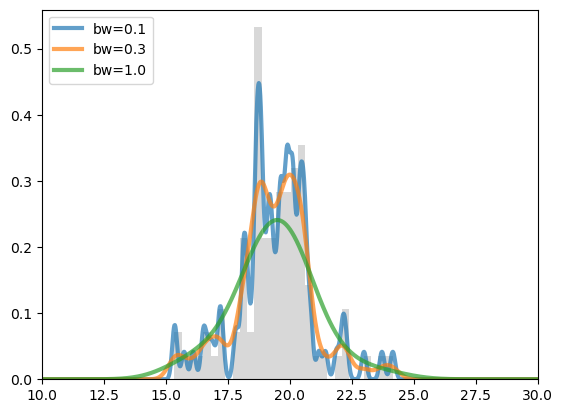

In [8]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(10, 30)
ax.legend(loc='upper left')

#### Bandwidth Cross-Validation in Scikit-Learn
Using cross validation within Scikit-learn is straightforward with the ``GridSearchCV`` meta-estimator:

In [50]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

{'bandwidth': 1.0}


In [52]:
f = lambda x: grid.score_samples(x[:, None])
f(np.array([1]))

array([-107.84959624])

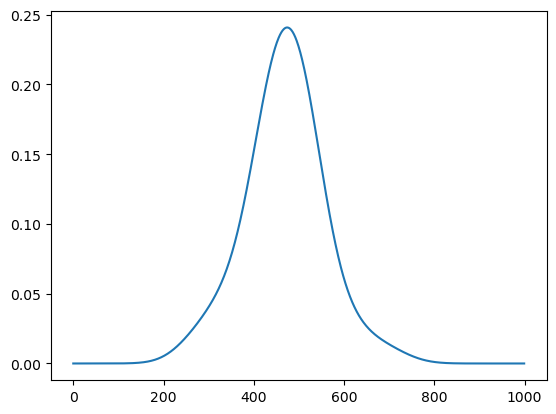

In [53]:
plt.plot(np.exp(grid.score_samples(x_grid[:, None])))

Text(0.5, 1.0, 'KDE using scikit-learn')

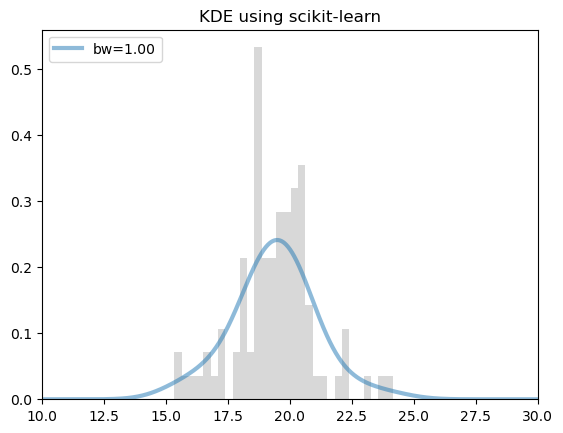

In [54]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(10, 30);
ax.set_title('KDE using scikit-learn')

#### Bandwidth Cross-Validation in Stats-models

In [55]:
def kde_statsmodels_m2(x, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return lambda x_i: kde.pdf(x_i)

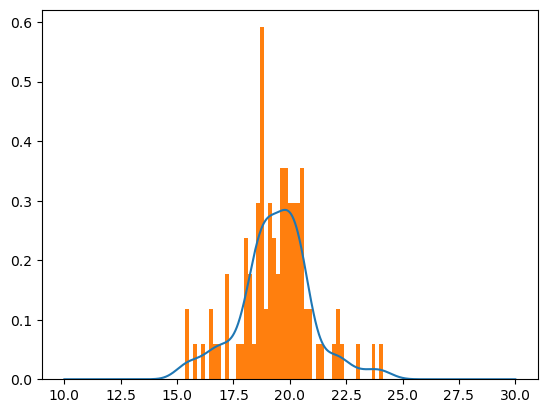

In [56]:
# How to obtain a function instead of an array of values from KDEMultivariate?
pdf = kde_statsmodels_m2(x)
plt.plot(x_grid, pdf(x_grid));
plt.hist(x, bins=50, density=True);

In [15]:
cdf= np.cumsum(pdf(x_grid))

In [16]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Probabilidad de densidad acumulada CDF')

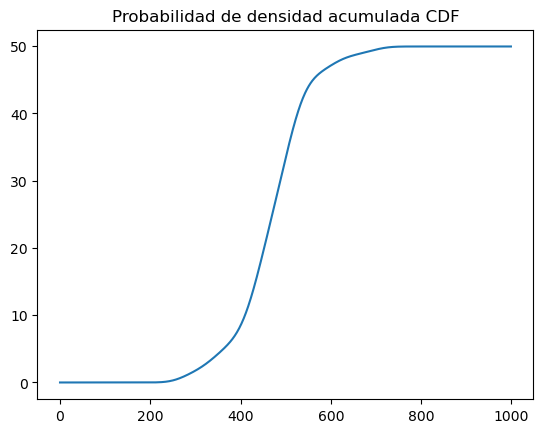

In [136]:
plt.plot(cdf)
plt.title("Probabilidad de densidad acumulada CDF")

In [121]:
from scipy import optimize
f = pdf
a=f(optimize.fmin(lambda x:-f(x), 0, disp=False))
t =lambda x: a * np.ones(len(x))
x = np.arange(10, 30, 0.01)
print('El máximo de f es:',a)

El máximo de f es: 0.28457366751666824


In [19]:
def Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x2 = f(R1)
    t_x2 = t(R1)
    condition = R2*t_x2 <=f_x2
    [plt.plot(R1[i],R2[i]*t_x2[i],'ob') if condition[i] else plt.plot(R1[i],R2[i]*t_x2[i],'o') \
         for i in range(len(R1))]
                
    plt.show()
    
    return x

In [119]:
# Función de aceptación y rechazo usando for
def Acep_rechazo2(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1)
    t_x = t(R1)
    condition = R2*t_x <=f_x
    for i in range(len(R1)):
        if condition[i]:
            plt.plot(R1[i],R2[i]*t_x[i],'ob')
        else:
            plt.plot(R1[i],R2[i]*t_x[i],'o')
    plt.show()

In [58]:
def Acep_rechazo3(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1)
    t_x = t(R1)
    condition = R2*t_x <=f_x
    x = [R1[i] for i in range(len(R1)) if condition[i]]
                
    return x

In [103]:
import random
[random.uniform(0, 1) for i in range(5)]

[0.6108894757913726,
 0.21711077980958526,
 0.5905003374285107,
 0.430904403482152,
 0.08643092066452907]

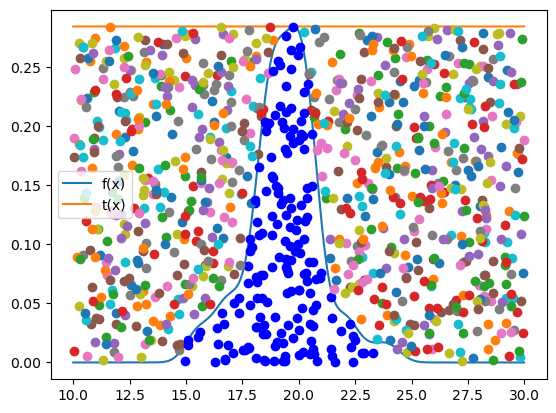

In [122]:
N = 1000
R2 = np.random.rand(N)
R1 = [random.uniform(10, 30) for i in range(N)]
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()
Acep_rechazo2(R2, R1, f, t)

In [123]:
Acep_rechazo3(R2, R1, f, t)

[17.7362990082352,
 19.661355545375706,
 21.432703525952334,
 18.10719251497095,
 18.521923660559207,
 16.707269101340124,
 21.40929719213321,
 22.25523782399285,
 16.86902744003227,
 19.407639241957167,
 19.41328890928245,
 17.102598939909328,
 18.147163685241726,
 22.424919008689667,
 16.263780164520462,
 19.6721972871166,
 18.068769739156174,
 17.776103845177897,
 18.241933957771842,
 15.537718849568094,
 20.50268502048855,
 19.948139794163673,
 20.53221778469159,
 17.845002891360373,
 17.357980602114623,
 20.693408118159564,
 18.574028681605647,
 19.824823370092616,
 20.764350345181047,
 22.489290355025553,
 18.856976738823544,
 20.20324473748814,
 18.9324038432561,
 18.790669529443193,
 19.744312472930062,
 18.35069810468254,
 17.745607739654545,
 20.63276590063439,
 18.828339641321516,
 20.092897067405048,
 20.281320586242266,
 19.525611231888362,
 15.069904640804868,
 23.288886501960263,
 19.675311763658684,
 19.599121950860678,
 20.65020351374998,
 16.437786328599888,
 20.42023

In [21]:
dif_inf = pd.read_excel(
    "Inflacion Mexico.xlsx",
    sheet_name="Hoja3",
    index_col=[0],
    usecols=[0, 1]
)
y= dif_inf.values
y= y.ravel()
y.shape

(96,)

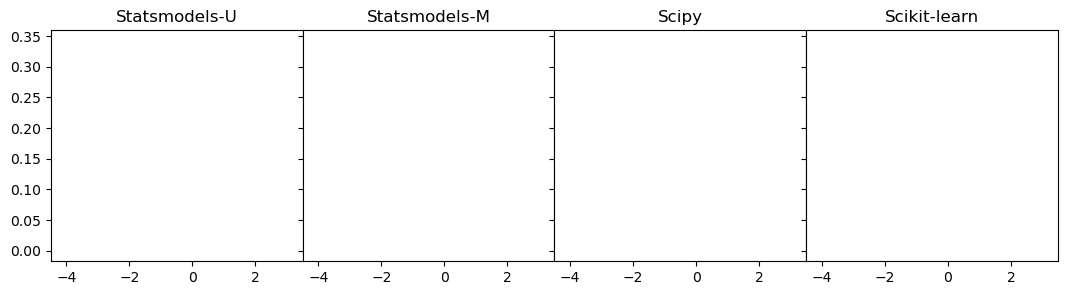

In [145]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
y_grid = np.linspace(0, 1.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
# x = np.concatenate([norm(-1, 1.).rvs(400),
#                     norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

<AxesSubplot:ylabel='Density'>

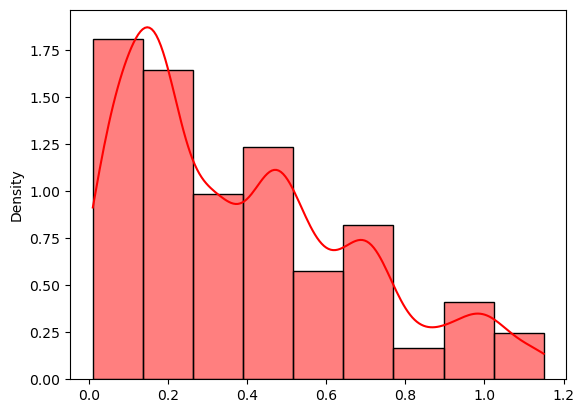

In [23]:
sns.histplot(data=y, stat='density', kde=True, kde_kws={'bw_method': .2}, color='r', bins=9)

<AxesSubplot:ylabel='Density'>

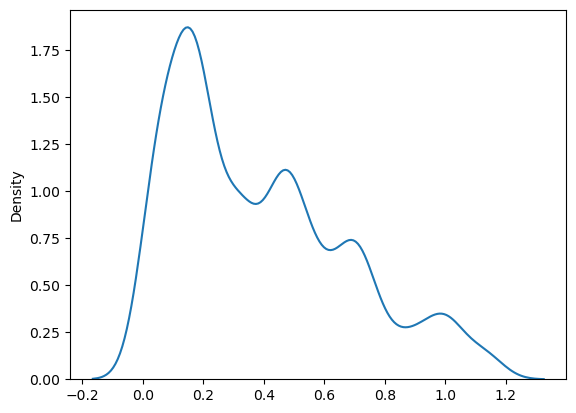

In [24]:
sns.kdeplot(data=y, bw_method=0.2)

### Bandwidth selection

The selection of bandwidth is an important piece of KDE.  For the same input data, different bandwidths can produce very different results:

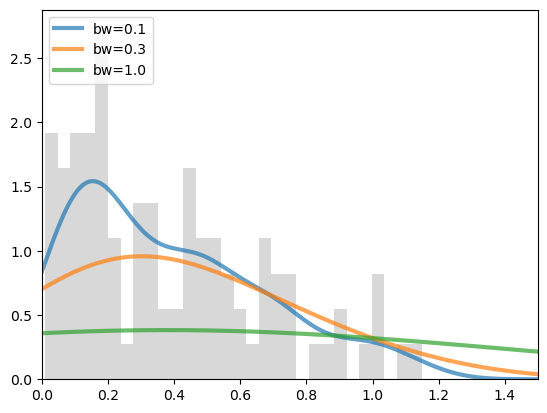

In [144]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(y_grid, kde_sklearn(y, y_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(y, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(0, 1.5)
ax.legend(loc='upper left')

#### Bandwidth Cross-Validation in Scikit-Learn
Using cross validation within Scikit-learn is straightforward with the ``GridSearchCV`` meta-estimator:

In [146]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(y[:, None])
print(grid.best_params_)

{'bandwidth': 0.1}


In [148]:
f = lambda y: grid.score_samples(y[:, None])
f(np.array([1]))

array([-1.23864039])

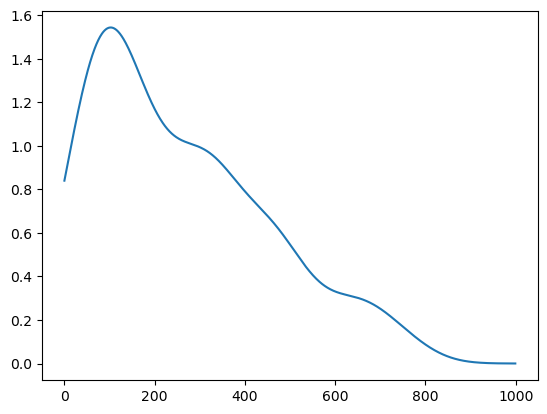

In [149]:
plt.plot(np.exp(grid.score_samples(y_grid[:, None])))

#### Bandwidth Cross-Validation in Stats-models

In [156]:
def kde_statsmodels_m2(y, bandwidth=0.1, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(y, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return lambda x_i: kde.pdf(x_i)

In [157]:
kde_statsmodels_m2(y)

C:\Users\av1la\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


<function __main__.kde_statsmodels_m2.<locals>.<lambda>(x_i)>

(array([2.28435673, 1.37061404, 1.82748538, 1.37061404, 2.28435673,
        0.91374269, 2.28435673, 4.56871345, 0.91374269, 0.91374269,
        0.45687135, 0.91374269, 0.        , 2.74122807, 0.91374269,
        0.45687135, 0.45687135, 0.91374269, 0.45687135, 2.28435673,
        1.37061404, 1.82748538, 0.        , 0.45687135, 1.37061404,
        0.45687135, 0.45687135, 0.45687135, 0.45687135, 1.37061404,
        0.91374269, 0.45687135, 1.37061404, 0.        , 0.        ,
        0.45687135, 0.45687135, 0.        , 0.        , 0.91374269,
        0.        , 0.        , 0.45687135, 0.91374269, 0.45687135,
        0.        , 0.        , 0.45687135, 0.        , 0.45687135]),
 array([0.01  , 0.0328, 0.0556, 0.0784, 0.1012, 0.124 , 0.1468, 0.1696,
        0.1924, 0.2152, 0.238 , 0.2608, 0.2836, 0.3064, 0.3292, 0.352 ,
        0.3748, 0.3976, 0.4204, 0.4432, 0.466 , 0.4888, 0.5116, 0.5344,
        0.5572, 0.58  , 0.6028, 0.6256, 0.6484, 0.6712, 0.694 , 0.7168,
        0.7396, 0.7624, 0.7852

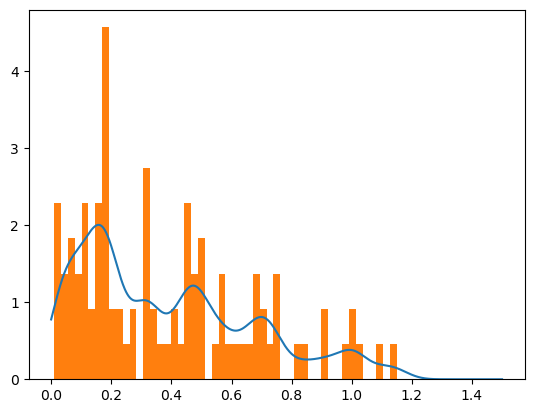

In [158]:
# How to obtain a function instead of an array of values from KDEMultivariate?
pdf_y = kde_statsmodels_m2(y)
plt.plot(y_grid, pdf_y(y_grid))
plt.hist(y, bins=50, density=True)

Text(0.5, 1.0, 'KDE using scikit-learn')

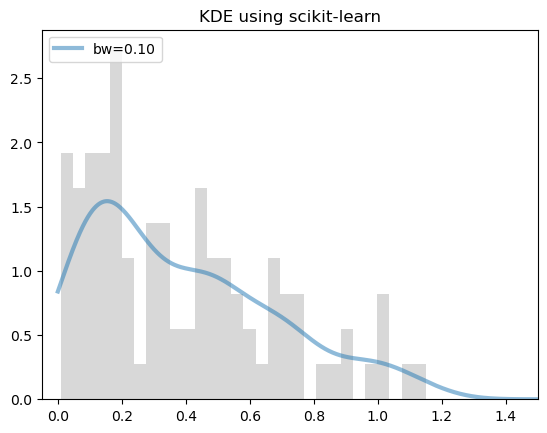

In [152]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(y_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(y_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(y, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-.05, 1.5, 30);
ax.set_title('KDE using scikit-learn')

In [35]:
cdf_y= np.cumsum(pdf_y(y_grid))

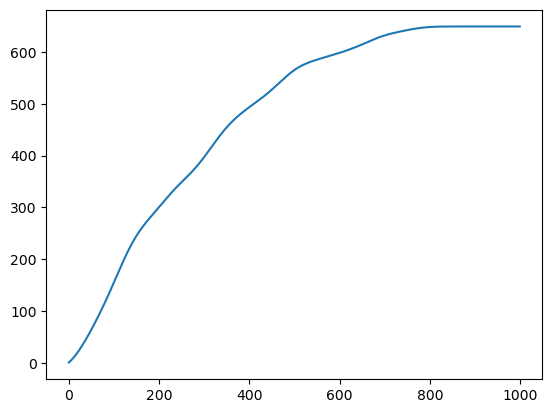

In [36]:
plt.plot(cdf_y)

In [160]:
from scipy import optimize
f = pdf_y
a=f(optimize.fmin(lambda x:-f(x), 0, disp=False))
t =lambda x: a * np.ones(len(x))
x = np.arange(-.5, 1.5, 0.01)
print('El máximo de f es:',a)

El máximo de f es: 2.0043417330670823


In [154]:
def Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x2 = f(R1)
    t_x2 = t(R1)
    condition = R2*t_x2 <=f_x2
    [plt.plot(R1[i],R2[i]*t_x2[i],'ob') if condition[i] else plt.plot(R1[i],R2[i]*t_x2[i],'o') \
         for i in range(len(R1))]
                
    plt.show();
    
    return x

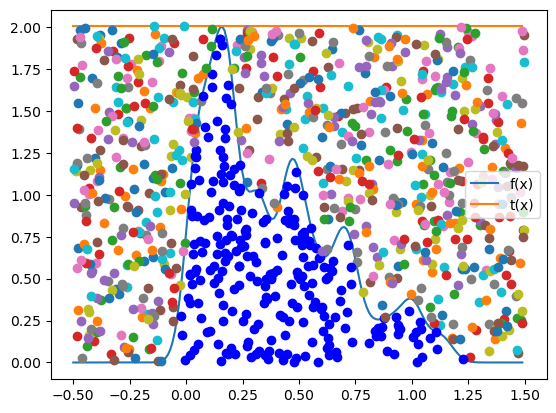

In [161]:
N = 1000
R2 = np.random.rand(N)
R1 = [random.uniform(-.5, 1.5) for i in range(N)]
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()
Acep_rechazo2(R2, R1, f, t)

In [129]:
Acep_rechazo3(R2, R1, f, t)

[0.502880883989985,
 0.7232131810400804,
 0.6390422608156676,
 0.2239730400810116,
 0.899209374350971,
 0.1166118743789133,
 0.03472050571704988,
 -0.01867969972135186,
 0.3474825686408225,
 0.03351756460811872,
 0.17055435948691633,
 0.29438682252648074,
 0.28610787503448765,
 0.20365018152957615,
 0.7047880235565744,
 0.016512564263251983,
 0.08981822291162445,
 0.15162317351665466,
 -0.011030323984727142,
 0.27233888533350736,
 0.5555064101229232,
 0.4820128217088504,
 0.8322419634367979,
 0.5142585800421988,
 0.562155284242756,
 0.10793417884348977,
 0.12249595630679377,
 0.2624636115714438,
 0.3102359900839269,
 0.08872489194823041,
 0.9187843254223178,
 0.39947388692909325,
 0.037520925328909716,
 0.45487728574220254,
 0.6852687187256803,
 0.1761371352360528,
 1.1827376221403711,
 0.17871426097883725,
 0.11645155554691544,
 0.28187996982632346,
 0.16565992196021972,
 0.6661306911889642,
 0.4064972761190111,
 0.7302359847634201,
 0.49830267819305596,
 0.15486794198393783,
 0.51628